<h1 style="text-align:center; font-size:40px; color:black;"> Analyzing Negative App Reviews with NLP and Clustering </h1>

<h1 style="font-size:32px;"> 📖 Project Summary </h1>

This project focuses on analyzing negative Google Play Store reviews to uncover the main issues users face with a mobile app. Using Natural Language Processing (NLP) techniques from NLTK, the text data was cleaned and prepared for analysis. K-means clustering from scikit-learn was then applied to group similar reviews into categories.



<h1 style="font-size:32px">🔬 Dataset Overview </h1>

The dataset used in this project comes from Google Play Store reviews. It contains user feedback along with the rating (or score) each user assigned to the app. The dataset is stored in a file called `reviews.csv`.


| Column      | Description                                                  |
|-------------|--------------------------------------------------------------|
| `content`   | The written text of each review. Since this is unstructured text, it requires preprocessing before applying NLP techniques. |
| `score`     | The numerical rating (1–5) given by the user. A score of **1** usually represents a very negative experience, while **5** indicates a highly positive one. |

For this project, the analysis focuses on **negative reviews** (mainly scores of 1 and 2). These reviews will be explored to uncover recurring issues and grouped into categories using clustering.  


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import re

In [2]:
# Download NLTK resources
# punkt -> Tokenization
# stopwords -> Stop words removal
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)

True

## 👀 Explore the Data

In [3]:
# Load the reviews dataset and preview it
reviews = pd.read_csv("reviews.csv")
reviews.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


In [4]:
# Shape of dataset (rows, columns)
print("Dataset shape:", reviews.shape)

# Data types and non-null counts
print("\nDataset info:")
print(reviews.info())

# Count missing values
print("\nMissing values per column:")
print(reviews.isnull().sum())


Dataset shape: (12495, 2)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12495 non-null  object
 1   score    12495 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 195.4+ KB
None

Missing values per column:
content    0
score      0
dtype: int64


---
No Cleaning needed.

## Explore score distribution

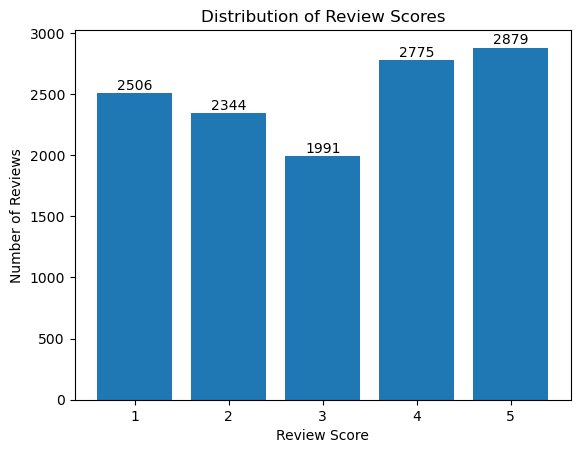

In [5]:
# Count how many reviews per score
score_counts = reviews['score'].value_counts().sort_index()

# Plot bar chart
plt.bar(score_counts.index, score_counts.values)

# Add labels
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores")

# Annotate bars with counts
for i, value in enumerate(score_counts.values):
    plt.text(score_counts.index[i], value + 30, str(value), ha='center')

plt.show()

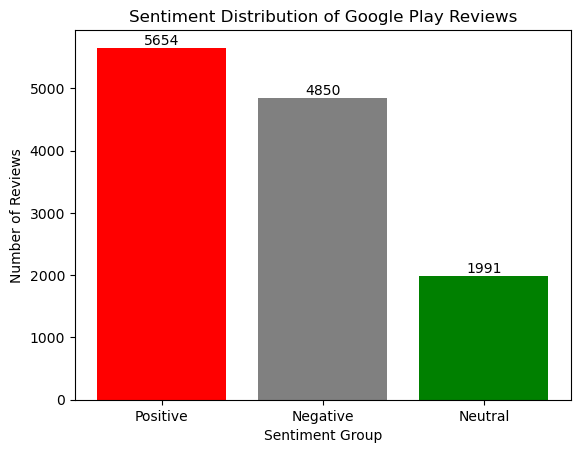

In [6]:
reviews['sentiment'] = reviews['score'].apply(
    lambda x: 'Negative' if x <= 2 else ('Positive' if x >= 4 else 'Neutral')
)

# Count per group
sentiment_counts = reviews['sentiment'].value_counts()

# Plot
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'gray', 'green'])
plt.xlabel("Sentiment Group")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution of Google Play Reviews")

for i, value in enumerate(sentiment_counts.values):
    plt.text(i, value + 50, str(value), ha='center')

plt.show()

---
- Negative reviews (1–2 stars) = 4,850 reviews (~39%)

- Positive reviews (4–5 stars) = 5,654 reviews (~45%)

- Neutral-ish (3 stars) = 1,991 reviews (~16%)

## Focus on negative reviews

Let’s filter reviews with scores 1 or 2.

In [7]:
negative_reviews = reviews[reviews['score'] <= 2].copy()
print("Number of negative reviews:", len(negative_reviews))

negative_reviews.head(10)

Number of negative reviews: 4850


,content,score,sentiment
0,I cannot open the app anymore,1,Negative
1,I have been begging for a refund from this app...,1,Negative
2,Very costly for the premium version (approx In...,1,Negative
3,"Used to keep me organized, but all the 2020 UP...",1,Negative
4,Dan Birthday Oct 28,1,Negative
5,It has changed how I viewed my different lists...,1,Negative
6,I'm only looking for a grocery list app but ev...,1,Negative
7,"Reset my free trial, new phone I'd like to see...",1,Negative
8,How do to stop monthly payment because i don't...,1,Negative
9,I complain about not crashes and it was immedi...,1,Negative


## 📝Text preprocessing (Cleaning)

To clean the text for NLP - remove punctuation, stopwords, etc.

In [8]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    text = str(text).lower()                           # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)               # Remove punctuation/numbers
    tokens = nltk.word_tokenize(text)                  # Tokenize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]  # Remove stopwords + lemmatize
    return " ".join(tokens)

# Apply preprocessing to negative reviews
negative_reviews['clean_content'] = negative_reviews['content'].apply(preprocess_text)

negative_reviews[['content', 'clean_content']].head()

,content,clean_content
0,I cannot open the app anymore,open app anymore
1,I have been begging for a refund from this app...,begging refund app month nobody replying
2,Very costly for the premium version (approx In...,costly premium version approx indian rupee per...
3,"Used to keep me organized, but all the 2020 UP...",used keep organized update made mess thing cud...
4,Dan Birthday Oct 28,dan birthday oct


---
#### Explanation:
- `str(text).lower()`: ensures all letters are lowercase.

- `re.sub(r'[^a-z\s]', '', text)`: removes numbers, punctuation, emojis, and special characters.

- `nltk.word_tokenize(text)`: splits sentences into individual words.

- `[lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]`: removes filler words and reduces words to their base form for consistency.

## Vectorize the cleaned negative reviews using TF-IDF

In [9]:
vectorizer = TfidfVectorizer()  
X = vectorizer.fit_transform(negative_reviews['clean_content'])

print("TF-IDF shape:", X.shape)

TF-IDF shape: (4850, 6764)


In [10]:
vectorizer.get_feature_names_out()[:20]  # First 20 words/features

array(['aa', 'aaah', 'aak', 'aap', 'aapako', 'abandon', 'abandoned',
       'abc', 'abd', 'abdon', 'abhorrent', 'ability', 'able', 'abou',
       'abound', 'abour', 'abre', 'abrir', 'abruptly', 'absolument'],
      dtype=object)

---

`TfidfVectorizer` converts text into numbers by weighing words based on frequency in the review vs. across all reviews.

## K-means Clustering

In [11]:
kmeans = KMeans(n_clusters=5, random_state=42)
negative_reviews['cluster'] = kmeans.fit_predict(X)

negative_reviews[['content', 'cluster']].head(10)

,content,cluster
0,I cannot open the app anymore,0
1,I have been begging for a refund from this app...,2
2,Very costly for the premium version (approx In...,3
3,"Used to keep me organized, but all the 2020 UP...",2
4,Dan Birthday Oct 28,2
5,It has changed how I viewed my different lists...,2
6,I'm only looking for a grocery list app but ev...,1
7,"Reset my free trial, new phone I'd like to see...",2
8,How do to stop monthly payment because i don't...,0
9,I complain about not crashes and it was immedi...,2


--- 

* `k = 5` means we’ll group reviews into 5 clusters. You can experiment with different values later.

* `fit_predict(X)` fits the K-means algorithm to the TF-IDF vectors and assigns each review a cluster label.

#### Check cluster sizes

In [12]:
# How many reviews in each cluster
negative_reviews['cluster'].value_counts().sort_index()

cluster
0    1201
1     623
2    2143
3     487
4     396
Name: count, dtype: int64

---
**Cluster 2 is the largest**, so it likely contains the most common complaints.

## 🔎 Viewing top words per cluster

In [13]:
def get_top_terms(vectorizer, kmeans, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Sort features by importance
    for i in range(kmeans.n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :n_terms]]
        print(f"Cluster {i}: {', '.join(top_terms)}")

get_top_terms(vectorizer, kmeans)

Cluster 0: app, calendar, use, sync, google, time, phone, dont, work, cant
Cluster 1: task, list, widget, work, app, doesnt, day, add, time, completed
Cluster 2: good, cant, account, like, premium, time, bad, dont, even, work
Cluster 3: version, ad, free, pro, app, full, paid, buy, premium, tree
Cluster 4: reminder, notification, app, work, feature, set, dont, time, task, alarm


---

#### Findings:

- Cluster 0 & 1: Functional issues with core app features (sync, tasks, widgets)

- Cluster 2: Account or subscription complaints

- Cluster 3: Pricing, ads, and version frustrations

- Cluster 4: Notifications and reminders

This analysis allows the product team to prioritize fixes by focusing on the largest clusters first (e.g., Cluster 2 has the most reviews, so account/premium issues affect many users).

##  📊 Visualize Top Words per Cluster

showing the most important words that define the cluster.  

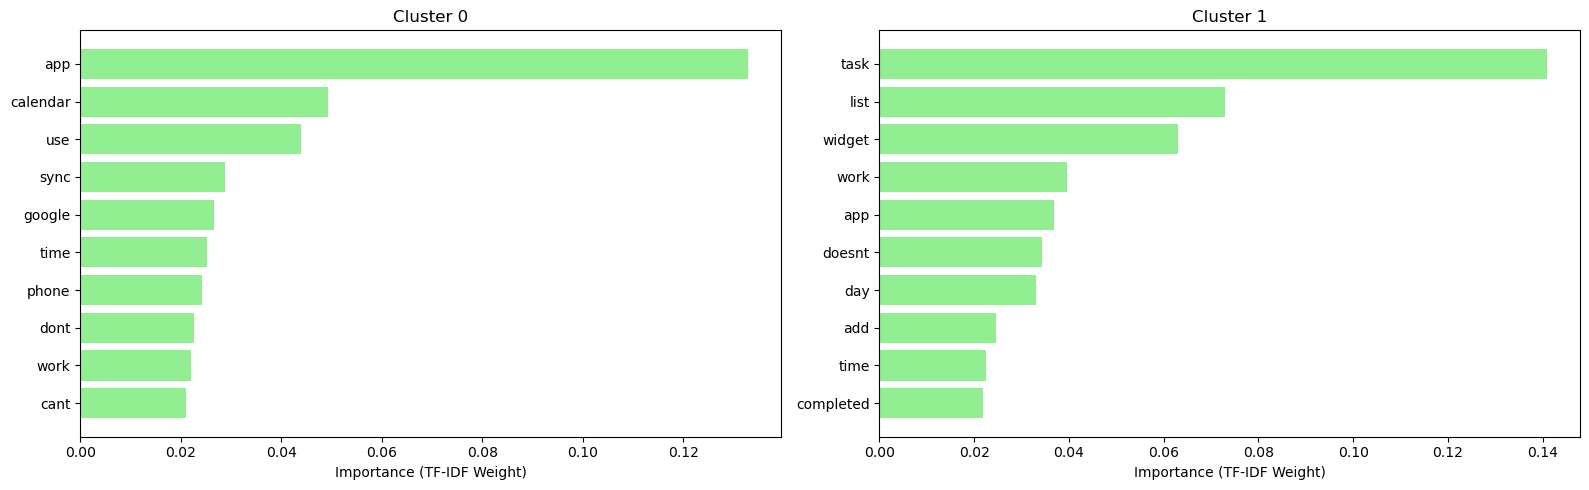

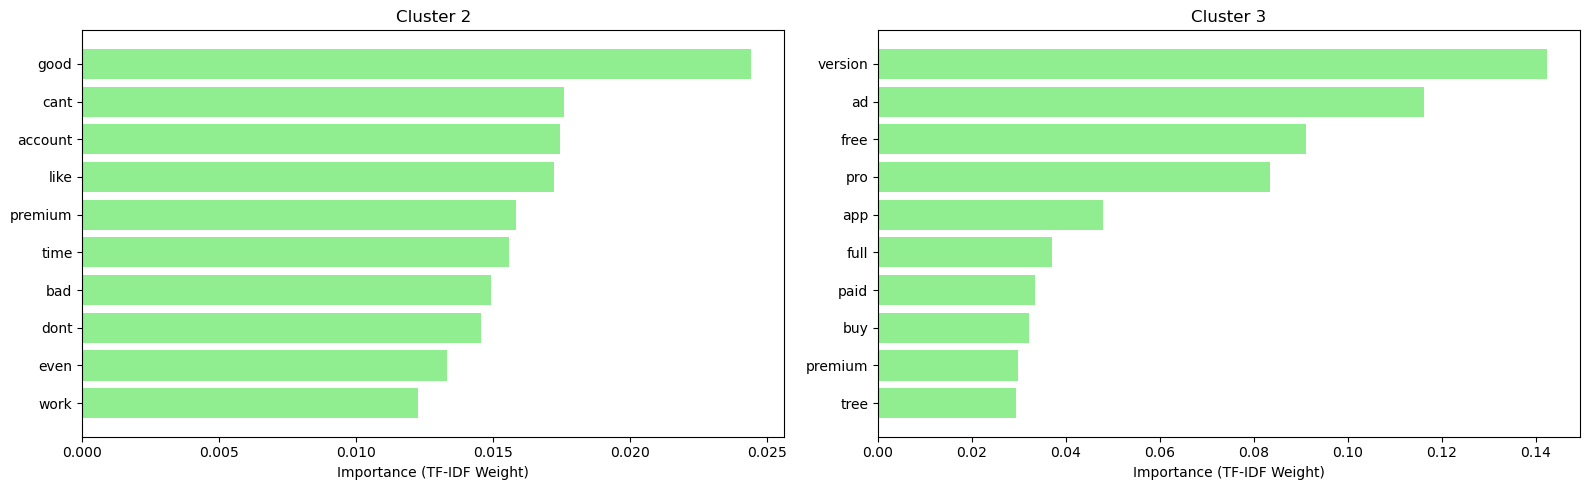

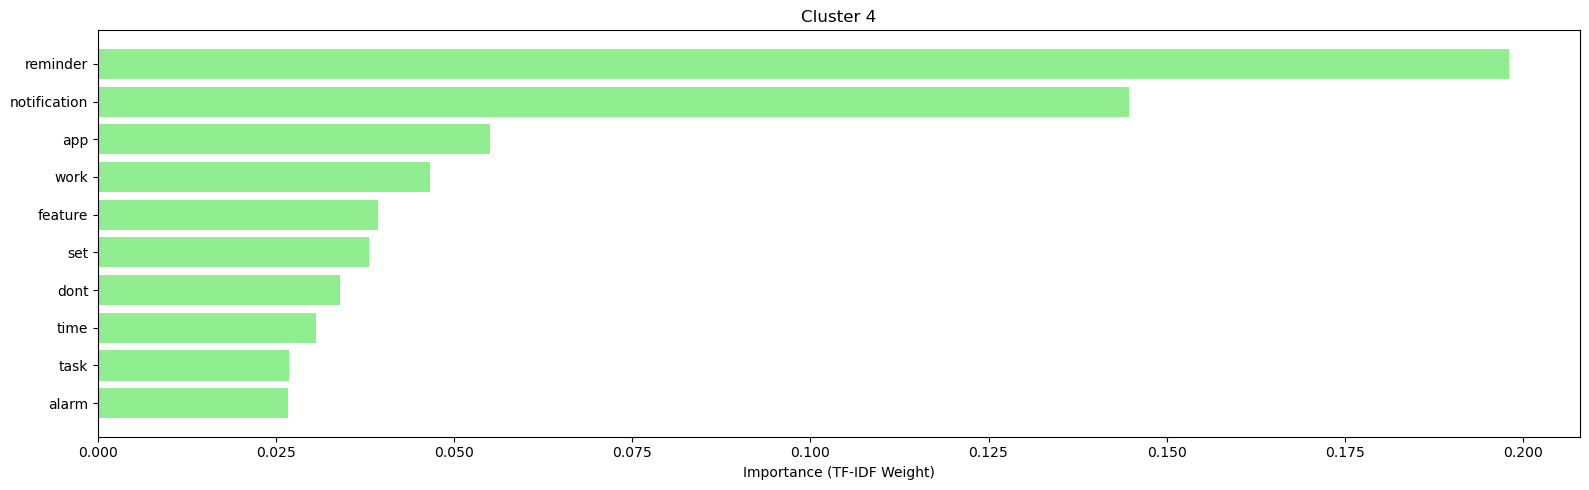

In [14]:
def plot_top_words_side_by_side(vectorizer, kmeans, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    
    num_clusters = kmeans.n_clusters
    i = 0
    while i < num_clusters:
        n_subplots = 2 if i + 1 < num_clusters else 1
        fig, axes = plt.subplots(1, n_subplots, figsize=(16,5))
        if n_subplots == 1:
            axes = [axes]  # Make it iterable
        
        for j in range(n_subplots):
            cluster_idx = i + j
            top_indices = order_centroids[cluster_idx, :n_terms]
            top_terms = [terms[ind] for ind in top_indices]
            top_weights = kmeans.cluster_centers_[cluster_idx, top_indices]
            
            axes[j].barh(top_terms[::-1], top_weights[::-1], color='lightgreen')
            axes[j].set_xlabel("Importance (TF-IDF Weight)")
            axes[j].set_title(f"Cluster {cluster_idx}")
        
        plt.tight_layout()
        plt.show()
        i += n_subplots

# Plot top words in side-by-side bar charts
plot_top_words_side_by_side(vectorizer, kmeans, n_terms=10)
